#Predicting PGA Championship Winners

In this notebook, we will attempt to predict the top 10 finishers of the  2015 PGA Championship. Using data from the Golf Channel's website, we will be using a variety of regressors to estimate final round scores, which can later be used to estimate 72-hole totals.

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import re
import requests as req
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from bs4 import BeautifulSoup

In [3]:
import warnings
warnings.filterwarnings('ignore')

###Web scraping tables from golfchannel.com

The Golf Channel website has PGA Championship data going back to 2005, excluding 2010, 2011, and 2013.

In [4]:
years = ['2005', '2006', '2007', '2008', '2009', '2012', '2014', '2015']

tables = []

for year in years:
    html = req.get('http://www.golfchannel.com/tours/pga-of-america/' + year + '/pga-championship/')
    soup = BeautifulSoup(html.content, "html.parser")
    table = soup.findAll('table')
    tables.append(table)

In [109]:
dictionaries = []

for table in tables:

    data = {}
    rows = table[1].findAll('tr')

    if len(soup.findAll('th')) > 0:
        rows = rows[1:]
    i=0
    
    for row in rows:

        try:
            cells = row.findAll('td')
            name = cells[3].get_text().strip()

            data[name] = {
                'POS' : re.sub("\D", "", cells[1].get_text()),
                'MOV' : cells[2].get_text().strip(),
                'OVERALL' : int(cells[4].get_text()),
                'THRU' : cells[5].get_text(),
                'RND' : cells[6].get_text(),
                'R1' : cells[7].get_text(),
                'R2' : cells[8].get_text(),
                'R3' : cells[9].get_text(),
                'R4' : int(cells[10].get_text()),
                'TOT' : cells[11].get_text()
            }
            
        except BaseException as e:
            i+=1
     
    dictionaries.append(data)

###Split data into training and testing set

Since we are trying to predict the final round scores of the 2015 tournament, we will use 2015's data in our testing set, and all previous years' data in our training set.

In [110]:
dicts = dictionaries[:6] # append all but 2015's data into new dataframe for training
dftrain = pd.DataFrame()
for d in dicts:
    dftemp = pd.DataFrame(d).T
    dftrain = dftrain.append(dftemp)

dftest = pd.DataFrame(dictionaries[7]).T # 2015's data for testing

###Test data

In [111]:
dftest

,MOV,OVERALL,POS,R1,R2,R3,R4,RND,THRU,TOT
"Aphibarnrat, Kiradech *",6,4,68,72,72,73,75,+3,F,292
"Bae, Sangmoon *",12,2,64,71,72,72,75,+3,F,290
"Bjorn, Thomas",12,-1,48,69,75,69,74,+2,F,287
"Bohn, Jason",13,-3,37,74,71,66,74,+2,F,285
"Bradley, Keegan *",3,1,61,76,70,72,71,-1,F,289
"Casey, Paul *",13,-4,30,70,70,70,74,+2,F,284
"Chappell, Kevin",28,-2,43,73,68,78,67,-5,F,286
"Coetzee, George *",6,-12,7,74,65,70,67,-5,F,276
"Day, Jason *",-,-20,1,68,67,66,67,-5,F,268
"Donald, Luke",13,-2,43,72,70,70,74,+2,F,286


###Training data

In [112]:
dftrain

,MOV,OVERALL,POS,R1,R2,R3,R4,RND,THRU,TOT
"Ames, Stephen",-,11,72,67,72,74,78,+8,F,291
"Appleby, Stuart",-,1,15,67,70,69,75,+5,F,281
"Austin, Woody",-,9,66,72,71,68,78,+8,F,289
"Bjorn, Thomas",-,-3,2,71,71,63,72,+2,F,277
"Bohn, Jason",-,5,34,71,68,68,78,+8,F,285
"Calcavecchia, Mark",-,10,70,70,69,77,74,+4,F,290
"Campbell, Chad",-,4,28,71,71,70,72,+2,F,284
"Campbell, Michael",-,-1,6,73,68,69,69,-1,F,279
"Casey, Paul",-,8,59,70,74,72,72,+2,F,288
"Choi, K.J.",-,6,40,71,70,73,72,+2,F,286


###Clean up the datasets

We don't want players who either didn't make the cut after the first two rounds, or withdrew from the tournament at any point. Also, we want to drop any features that won't be useful in our predictions.

In [98]:
dftrain.columns = ['MOV', 'OVERALL', 'POS', 'R1', 'R2', 'R3', 'R4', 'RND', 'THRU', 'TOT']

dftrain = dftrain[dftrain.POS != 'WD']
dftrain = dftrain[dftrain.POS != 'CUT']

dftrain = dftrain.drop(dftrain.columns[[0, 1, 2, 7, 8, 9]], 1)

dftrain = dftrain.convert_objects(convert_numeric=True)

In [99]:
dftest.columns = ['MOV', 'OVERALL', 'POS', 'R1', 'R2', 'R3', 'R4', 'RND', 'THRU', 'TOT']

dftest = dftest[dftest.POS != 'WD']
dftest = dftest[dftest.POS != 'CUT']

dftest = dftest.drop(dftest.columns[[0, 1, 2, 7, 8, 9]], 1)

dftest = dftest.convert_objects(convert_numeric=True)

In [100]:
y = dftrain[[3]]
x = dftrain[[0, 1, 2]]

In [101]:
lm = LinearRegression()
lm.fit(x, y)
lmpred = lm.predict(dftest[[0, 1, 2]])

print(lm.intercept_)
print(lm.coef_)

[ 57.87174448]
[[ 0.10650248 -0.04103787  0.14440993]]


In [102]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(x, y)
rfpred = rfr.predict(dftest[[0, 1, 2]])

In [103]:
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=3, loss='ls')
gbr.fit(x, y)
gbpred = gbr.predict(dftest[[0, 1, 2]])

In [104]:
dftest['lmpredR4'] = lmpred
dftest['rfpredR4'] = rfpred
dftest['gbpredR4'] = gbpred
#dftest['avgpredR4'] = dftest[['lmpredR4', 'rfpredR4']].mean(axis=1)

In [105]:
dftest['TOT'] = dftest[[0, 1, 2, 3]].sum(axis=1)
dftest['predTOT'] = dftest[[0, 1, 2, 4]].sum(axis=1)

In [106]:
dftest.sort('predTOT')

,R1,R2,R3,R4,lmpredR4,rfpredR4,gbpredR4,TOT,predTOT
"Day, Jason *",68,67,66,67,71.895431,72.480000,72.762110,268,272.895431
"Spieth, Jordan",71,67,65,68,72.070528,72.030000,72.042524,271,275.070528
"Grace, Branden",71,69,64,69,71.844043,71.150000,71.181509,273,275.844043
"Rose, Justin *",69,67,68,70,72.290753,72.624167,72.407917,274,276.290753
"Kaymer, Martin *",70,70,65,73,71.840912,70.571667,71.113991,278,276.840912
"Finau, Tony",71,66,69,71,72.689206,70.140000,70.857706,277,278.689206
"Johnson, Dustin *",66,73,68,69,71.725018,74.930000,73.168786,276,278.725018
"Jones, Matt",68,65,73,75,72.988376,73.630000,73.489701,281,278.988376
"Lahiri, Anirban",70,67,70,68,72.686075,74.511000,71.792185,275,279.686075
"Kuchar, Matt *",68,72,68,68,71.979061,71.780000,72.966196,276,279.979061


In [44]:
Correlation = dftest[['TOT', 'predTOT']].corr()
Correlation

,TOT,predTOT
TOT,1.00000,0.87832
predTOT,0.87832,1.00000


In [45]:
RSq = (dftest[['TOT', 'predTOT']].corr())**2
RSq

,TOT,predTOT
TOT,1.000000,0.771446
predTOT,0.771446,1.000000


In [46]:
mean_squared_error(dftest['TOT'], dftest['predTOT'])

10.616211212266956

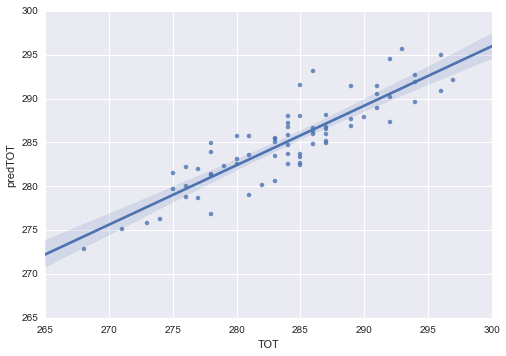

In [50]:
sns.regplot('TOT', 'predTOT', dftest)